In [2]:
import torch as tr
if tr.backends.mps.is_available():
    mps_device = tr.device("mps")
    x = tr.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [ ]:
#work with mps device
#mps_device = tr.device("mps")
start = tr.mps.event.Event(enable_timing=True)
x = tr.ones(1, device=mps_device)
end = tr.mps.event.Event(enable_timing=False)
print (start.elapsed_time(end))

In [20]:
import time
import torch

device = "mps"

torch.manual_seed(1234)
TENSOR_A_CPU = torch.rand(50, 50).to(torch.float32)
TENSOR_B_CPU = torch.rand(50, 50).to(torch.float32)

torch.manual_seed(1234)
TENSOR_A_MPS = torch.rand(50, 50).to(device).to(torch.float32)
TENSOR_B_MPS = torch.rand(50, 50).to(device).to(torch.float32)

# Warm-up
for _ in range(100):
    torch.matmul(torch.rand(50,50).to(device), torch.rand(50,50).to(device))
    
start_time = time.time()
torch.matmul(TENSOR_A_CPU, TENSOR_B_CPU)
print("CPU : --- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
torch.matmul(TENSOR_A_MPS, TENSOR_B_MPS)
print("MPS : --- %s seconds ---" % (time.time() - start_time))

CPU : --- 8.296966552734375e-05 seconds ---
MPS : --- 0.00023603439331054688 seconds ---


In [2]:
# this is not compatible with MPS
tr.set_default_dtype(tr.float32)
tr.set_printoptions(precision=16)
tr.set_printoptions(edgeitems=8)  # Aumenta la cantidad de elementos impresos

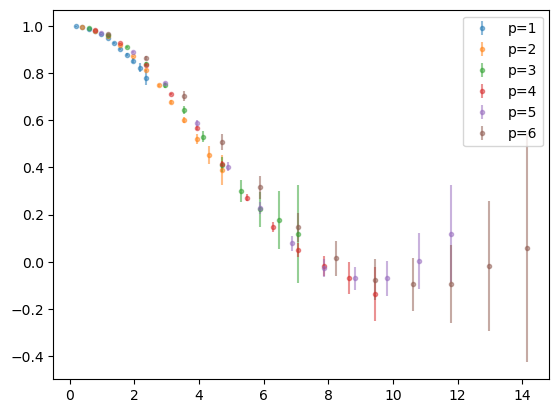

In [3]:
import torch as tr
import numpy as np
import matplotlib.pyplot as plt

from torch.special import gammaln
from torch.autograd.functional import hessian

import scipy.integrate as integrate

import h5py as h5

# import all packages and set plots to be embedded inline
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import minimize 
from scipy import special 
from scipy.optimize import Bounds 
from scipy.linalg import cho_solve 
from pyDOE import lhs 
import time
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import Pipeline 
import torch as tr
import scipy.integrate as integrate 
import scipy.special

def get_dist_matelem(z, p, t_min):
    f = 0
    if p <= 3:
        f = h5.File('NF2+1/ratio.summationLinearFits.cl21_32_64_b6p3_m0p2350_m0p2050.unphased.hdf5','r')
    else:
        f = h5.File('NF2+1/ratio.summationLinearFits.cl21_32_64_b6p3_m0p2350_m0p2050.phased-d001_2.00.hdf5','r')
    M_z_p = np.array(f['MatElem/bins/Re/mom_0_0_+'+str(p)+'/disp_z+'+str(z)+'/insertion_gt/tsep_'+str(t_min)+'-14'])
    M_0_0 = np.array(f['MatElem/bins/Re/mom_0_0_0/disp_0/insertion_gt/tsep_'+str(t_min)+'-14'])
    M_z_0 = np.array(f['MatElem/bins/Re/mom_0_0_0/disp_z+'+str(z)+'/insertion_gt/tsep_'+str(t_min)+'-14'])
    M_0_p = np.array(f['MatElem/bins/Re/mom_0_0_+'+str(p)+'/disp_0/insertion_gt/tsep_'+str(t_min)+'-14'])
    
    f.close()
    return M_z_p * M_0_0 / M_0_p / M_z_0

def get_final_res(z, p):
    m_4, _ = get_dist_matelem(z, p, 4)
    m_6, s_6 = get_dist_matelem(z, p, 6)
    m_8, s_8 = get_dist_matelem(z, p, 8)
    return m_6, np.sqrt(s_6**2)#+(m_4-m_6)**2)

Np = 6
Nz = 12
Nj = 349
rMj = np.empty([Nj,Np,Nz])
nu = np.empty([Np,Nz])
for p in range(1,Np+1):
    for z in range (1,Nz+1):
        nu[p-1,z-1] = 2.0*np.pi/32.0 *p *z
        #print(p,z,nu[p-1,z-1])
        m_4 = get_dist_matelem(z,p,4)
        m_6 = get_dist_matelem(z,p,6)
        m_8 = get_dist_matelem(z,p,8)
        #expo fit
        m = (m_4*m_8 - m_6**2)/(m_4 + m_8 - 2 * m_6)
        # this fails for certain cases where the denomenator goes too close to zero
        # use the m_6 as default
        rMj[:,p-1,z-1] = m_6
        #Nj=m.shape[0]
        #print(z,p,np.mean(m_4),np.mean(m_6),np.mean(m_8), np.mean(m),np.std(m)*np.sqrt(Nj-1))
rM = np.mean(rMj,axis=0)
rMe = np.std(rMj,axis=0)*np.sqrt(Nj) 
#plot the data
for i in range(0,6):
    plt.errorbar(nu[i],rM[i],yerr=rMe[i],fmt='.',alpha=0.5,label='p='+str(i+1))
plt.legend()
plt.show()

In [19]:
from GP import GaussianProcess

In [4]:
import numpy as np
import scipy.integrate as integrate
from torch.special import gammaln
import torch as tr
#from orthogonal_poly import legendre_01

class FE_Integrator:
    def __init__(self,x):
        self.N = x.shape[0]
        xx = np.append(x,2.0*x[self.N-1] - x[self.N-2])
        self.x = np.append(0,xx)
        self.eI = 0

        self.Norm = np.empty(self.N)
        for i in range(self.N):
            self.Norm[i] = self.ComputeI(i, lambda x : 1)
            
    def pulse(self,x,x1,x2):
        return np.heaviside(x-x1,0.5)* np.heaviside(x2-x,0.5)
    
    def f(self,x,i):
 ##       if(i==0):
 ##           R=(x- self.x[2])/(self.x[1] -self.x[2])*np.heaviside(x-self.x[0],1.0)* np.heaviside(self.x[2]-x,0.5)

            #R= self.pulse(x,self.x[0],self.x[1])
            #R= (x- self.x[0])/(self.x[1] -self.x[0])*self.pulse(x,self.x[0],self.x[1])
            #R+=(x- self.x[2])/(self.x[1] -self.x[2])*self.pulse(x,self.x[1],self.x[2])
            #R+=(x- self.x[1])/(self.x[0] -self.x[1])*self.pulse(x,self.x[0],self.x[1]) 
##            return R
        ii=i+1
        R = (x- self.x[ii-1])/(self.x[ii] -self.x[ii-1])*self.pulse(x,self.x[ii-1],self.x[ii  ])
        R+= (x- self.x[ii+1])/(self.x[ii] -self.x[ii+1])*self.pulse(x,self.x[ii  ],self.x[ii+1])

       # if(i==0):
       #     R *=2
        return R
    
    def set_up_integration(self,Kernel = lambda x: 1):
        res = np.empty(self.N)
        for i in range(self.N):
            res[i] = self.ComputeI(i,Kernel)
        return res
   
    # assume symmetrix function F(x,y) = F(y,x)
    # for efficiency
    def set_up_dbl_integration(self,Kernel = lambda x,y: 1):
        res = np.empty([self.N,self.N])
        for i in range(self.N):
            for j in range(i,self.N):
                res[i,j] = self.ComputeIJ(i,j,Kernel)
                res[j,i]  = res[i,j]
        #res[0,:] *=2
        #res[:,0] *=2
        return res
        
    def ComputeI(self,i,Kernel):
        I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,i), self.x[i], self.x[i+2])
        self.eI += eI
        return I
    
    def ComputeIJ(self,i,j,Kernel):
        I,eI = integrate.dblquad(lambda x,y: self.f(x,i)*Kernel(x,y)*self.f(y,j), self.x[j], self.x[j+2],self.x[i], self.x[i+2])
        self.eI += eI
        return I
    
    
# quadratic finite elements are more complicated...
# ... but now it works!
# also I should try the qubic ones too
class FE2_Integrator:
    def __init__(self,x):
        self.N = x.shape[0]
        xx = np.append(x,[2.0*x[self.N-1] - x[self.N-2], 3.0*x[self.N-1]-2*x[self.N-2],0] )
        #self.x = np.append([-x[0],0],xx)
        self.x = np.append(0,xx)
        self.eI = 0

        self.Norm = np.empty(self.N)
        for i in range(self.N):
            self.Norm[i] = self.ComputeI(i, lambda x : 1)
            
    def pulse(self,x,x1,x2):
        return np.heaviside(x-x1,0.5)* np.heaviside(x2-x,0.5)
    
    def f(self,x,i):
        R=0.0
        if(i==0):
            #R=self.pulse(x,self.x[0],self.x[1])
            #R=self.pulse(x,self.x[1],self.x[2])
        #    R+=(x- self.x[2])/(self.x[1] -self.x[2])*self.pulse(x,self.x[1],self.x[2])

            R+=(x- self.x[2])*(x- self.x[3])/((self.x[1] -self.x[3])*(self.x[1] -self.x[2]))**np.heaviside(x-self.x[0],1.0)* np.heaviside(self.x[3]-x,0.5)
            #self.pulse(x,self.x[0],self.x[3])
            return R
        ii =i+1
        if(ii%2==0):
            R  += (x- self.x[ii-1])*(x- self.x[ii+1])/((self.x[ii] -self.x[ii+1])*(self.x[ii] -self.x[ii-1]))*self.pulse(x,self.x[ii-1],self.x[ii+1])
            return R
        else:
            R += (x- self.x[ii-2])*(x- self.x[ii-1])/((self.x[ii] -self.x[ii-2])*(self.x[ii] -self.x[ii-1]))*self.pulse(x,self.x[ii-2],self.x[ii  ])
            R += (x- self.x[ii+1])*(x- self.x[ii+2])/((self.x[ii] -self.x[ii+2])*(self.x[ii] -self.x[ii+1]))*self.pulse(x,self.x[ii  ],self.x[ii+2])
            return R
    
        return R
    
    def set_up_integration(self,Kernel = lambda x: 1):
        res = np.empty(self.N)
        for i in range(self.N):
            res[i] = self.ComputeI(i,Kernel)
        return res
        
    # assume symmetrix function F(x,y) = F(y,x)
    # for efficiency 
    def set_up_dbl_integration(self,Kernel = lambda x,y: 1):
        res = np.empty([self.N,self.N])
        for i in range(self.N):
            for j in range(i,self.N):
                res[i,j] = self.ComputeIJ(i,j,Kernel)
                res[j,i]  = res[i,j]
        return res
    
    def ComputeI(self,i,Kernel):
        #if(i==0):
        #    I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,0), self.x[0], self.x[3])
        #    self.eI += eI
        #    return I
        ii=i+1
        if(ii%2==0):
            I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,i), self.x[ii-1], self.x[ii+1])
            self.eI += eI
        else:
            I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,i), self.x[ii-2], self.x[ii+2])
            self.eI += eI
        return I
    
    def ComputeIJ(self,i,j,Kernel):
        # I need to fix the i=0 case
        ii=i+1
        jj=j+1
        if(ii%2==0):
            xx = (self.x[ii-1], self.x[ii+1])
        else:
            xx = (self.x[ii-2], self.x[ii+2])
        if(jj%2==0):
            yy = (self.x[jj-1], self.x[jj+1])
        else:
            yy = (self.x[jj-2], self.x[jj+2])
        
        I,eI = integrate.dblquad(lambda x,y: self.f(x,i)*Kernel(x,y)*self.f(y,j), yy[0], yy[1],xx[0], xx[1])
        self.eI += eI

        return I

def interp(x,q,fe):
    S = 0*x
    for k in range(fe.N):
        S+= fe.f(x,k)*q[k]
    return S

class simple_PDF():
    def __init__(self,a,b,g): 
        self.a=a
        self.b=b
        self.g=g
        self.r = 1.0
        self.F = lambda y: (y**a*(1-y)**b*(1 + g*np.sqrt(y)))/self.r
        self.r,e = integrate.quad(self.F,0.0,1.0)  

def simplePDFnormed(x,a,b):
    return x**a*(1-x)**b*tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))




def very_simplePDFnormed(x,b):
    return (1-x)**b*tr.exp(gammaln(b+2) - gammaln(b+1))

# Posterior GP V2 with split RBF kernel
def pseudo_data(nu,a,b,g,da,db,dg,N):
    sa = np.random.normal(a,da,N)
    sb = np.random.normal(b,db,N)
    sg = np.random.normal(g,dg,N)

    D = np.zeros((N,nu.shape[0]))
    Norm=1.0
    for k in range(N):
        for i in range(nu.shape[0]):
            F =  lambda y: y**sa[k]*(1-y)**sb[k]*(1 + sg[k]*np.sqrt(y)-0.1*y)*np.cos(nu[i]*y) 
            r,e = integrate.quad(F,0.0,1.0) 
            D[k,i] = r
            if i==0:
                Norm = r
            D[k,i] = D[k,i]/Norm
    #add additional gaussian noise to break correlations
    NN = np.random.normal(0,1e-2,np.prod(D.shape)).reshape(D.shape)
    return D+NN

def autograd(func,x):
    x_tensor = x.clone().detach()
    x_tensor.requires_grad_()
    y = func(x_tensor)
    y.backward()
    return x_tensor.grad

#this is wrong
def HMC(func1,eps,L,current_q,diagonal=0.01*tr.tensor([0.2,1.0,1.0,1.0,0.01,1.1,0.1])):
    # setup
    #random seed?
    q=current_q
    #diagonal=tr.tensor([0.001,0.1,0.01,0.01,0.01,1.1,0.01])
    #diagonal=0.01*tr.tensor([0.2,1.0,1.0,1.0,0.01,1.1,0.1])
    #diagonal=tr.ones(X.shape[0])
    Covariace= tr.diag(diagonal)

    #propose a momentum distribution of the same shape as the position with torch
    p = tr.distributions.MultivariateNormal(tr.zeros_like(q),covariance_matrix=Covariace).sample()
    #print(p)
    current_p = p
    #p = current_p
    grad_U = autograd(func1,q)
    # make a half step for momentum at the beginning
    p = p - eps/2.0 * grad_U
    # alternate full steps for position and momentum
    for i in range(L+1):
        # make a full step for the position
        q = q + eps * p
        # make a full step for the momentum, except at end of trajectory
        if i!=L-1:
            p = p - eps * grad_U
    # make a half step for momentum at the end
    p = p - eps/2.0 * grad_U
    # negate the momentum at the end of the trajectory to make the proposal symmetric
    p = -p
    # evaluate potential and kinetic energies at start and end of trajectory
    current_U = func1(current_q)
    current_K = tr.sum(current_p**2)/2.0
    proposed_U = func1(q)
    proposed_K = tr.sum(p**2)/2.0
    # accept or reject the state at end of trajectory, returning either the position at the end of the trajectory or the initial position
    if np.random.uniform(0,1.0) < tr.exp(current_U-proposed_U+current_K-proposed_K).item():
        return q
    else:
        return current_q

class HMC_sampler():
    def __init__(self,logfunc,diagonal,grad=None):
        self.logfunc = logfunc
        self.diagonal = diagonal
        self.grad = grad
    def gibbs(self):
        self.p0 = tr.distributions.MultivariateNormal(tr.zeros_like(self.diagonal),covariance_matrix=tr.diag(self.diagonal)).sample()
        return self.p0

    def HMC_1(self,q0,p0,eps,L):
        self.eps=eps
        self.L=L
        self.q0=q0
        
        q = q0
        p = p0
        #CURRENT HAMILTONIAN
        H0=self.hamiltonian(q0,p0)
        if self.grad is None:
            #grad_U = -autograd(self.logfunc,q)
            p = p - self.eps/2.0 * autograd(self.logfunc,q)
            for i in range(self.L):
                if tr.isnan(q).any() and tr.isnan(p).any():
                    print('rejected in leapfrog')
                    return q0,p0,0
                q = q + self.eps * p
                if i!=self.L-1:
                    if  tr.isinf(self.logfunc(q)).item():
                        print('rejected in leapfrog 2')
                        return q0,p0,0
                    else:
                        p = p - self.eps *autograd(self.logfunc,q)
            p = p - self.eps/2.0 * autograd(self.logfunc,q)
            #reversibility
            #p = -p
        else:
            p = p - self.eps/2.0 * self.grad(q)
            for i in range(self.L):
                q = q + self.eps * p
                if i!=self.L-1:
                    p = p - self.eps * self.grad(q)
            p = p - self.eps/2.0 * self.grad(q)
            p = -p

        #PROPOSED HAMILTONIAN
        H1=self.hamiltonian(q,p)
        #delta H= H0-H1
        ΔH=H0-H1


        prob=tr.min(tr.tensor([1.0,tr.exp(ΔH)]))
        if tr.isnan(q).any() and tr.isnan(p).any():
                print('rejected after leapfrog')
                return q0,p0,ΔH

        if np.random.uniform(0,1.0) < prob.item():
            self.flag=True
            return q,p,ΔH
        else:
            self.flag=False
            print('rejected')
            return q0,p0,ΔH
        
    def hamiltonian(self,q,p):
        return self.logfunc(q) + tr.sum(p**2)/2.0
    
    def sample(self,q0,Nsamp,eps,L):
        self.traceq = tr.zeros(Nsamp,q0.shape[0])
        self.tracep = tr.zeros(Nsamp,q0.shape[0])
        self.traceH = tr.zeros(Nsamp,1)
        self.traceq[0] = self.q0
        self.p0 = self.gibbs()
        self.tracep[0] = self.p0
        self.eps=eps
        self.L=L
        for i in range(1,Nsamp):
            self.p0 = self.gibbs()
            q,p,ΔH = self.HMC_1(self.traceq[i-1],self.p0,self.eps,self.L)
                
            self.traceq[i] = q
            self.tracep[i] = p
            self.traceH[i] = ΔH
        return self.traceq,self.tracep,self.traceH
    
    def epsilonsqtest(self,ini,fin,NL,q0):
        #create new variables
        #eps0=self.eps
        self.q0= q0
        p0=self.gibbs()
        LT=(tr.linspace(ini,fin,NL)).type(tr.int32)
        epsT=(1/LT)
        #H0=self.hamiltonian(q0,p0)
        ΔH=tr.zeros(epsT.shape[0])
        i=0
        print(epsT,LT)
        while i<(epsT.shape[0]):
            
            self.eps=epsT[i]
            self.L=LT[i]
            
            #H0=self.hamiltonian(q0,p0)
            q,p,ΔH1 = self.HMC_1(q0,p0,epsT[i],LT[i])
            if self.flag:
                ΔH[i]=ΔH1
                print(epsT[i],ΔH[i])
                i=i+1
            else:
                print('rejected')
                continue
        #self.eps=eps0
        return epsT,ΔH


def KrbfMat(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return s*s*tr.exp(-0.5*((xx - yy)/w)**2)

""" def KlegeMat(x,*d):
    deg = len(d) -1
    L = legendre_01(x,deg)
    for i in range(len(d)):
        L[:,i]*=d[i]
    return L@tr.diag((2*tr.arange(0,deg+1,dtype=x.dtype)+1))@L.T

def KlegeMat_v0(x,d):
    deg = d.shape[0]-1
    L = legendre_01(x,deg)
    return L@tr.diag(d**2*(2*tr.arange(0,deg+1,dtype=x.dtype)+1))@L.T

class PolyKer():
    def __init__(self,degree=10):
        self.deg =degree

    def KerMat(self,x,s):
        L = legendre_01(x,self.deg)
        return L@tr.diag(s*s*(2*tr.arange(0,self.deg+1,dtype=x.dtype)+1))@L.T
 """
class splitRBFker():
    def __init__(self,sp,scale=1):
        self.sp =sp
        self.scale = scale
    def KerMat(self,x,s1,w1,s2,w2):
        K2 = KrbfMat(x,s2,w2) # linear
        K1 = KrbfMat(tr.log(x),s1,w1)
        sig = tr.diag(tr.special.expit(self.scale*(x-self.sp)))
        sigC = tr.eye(x.shape[0])-sig
        ##return K1+K2
        return sigC@K2@sigC + sig@K1@sig

def Sig(x,scale,sp=0.1):
    return tr.special.expit(scale*(x-sp))
def transform(s):
    return s.view(s.shape[1],1).repeat(1,s.shape[1])

#  write the last one as a function
def splitRBFkerMat(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    #plot this values and it looks like a simple rbf kernel
    #s1,w1,s2,w2,scale,sp =  1.0,0.1,1.0,2.2,1.0,.1
    K1 = KrbfMat(x,s1,w1) # linear
    K2 = KrbfMat(tr.log(x+eps),s2,w2) #log
    xx=x.view(1,x.shape[0])
    ss=Sig(xx,scale,sp)
    s=transform(ss)
    #sig=sig.view(1,sig.shape[1]).repeat(sig.shape[1],1)
    sC = 1-s
    return  s*K1*s.T +sC*K2*sC.T

#DERIVATIVES
def Krbf_ds(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return 2*s*tr.exp(-0.5*((xx - yy)/w)**2)
    #return  2*s*tr.exp(-0.5*((x.view(1,x.shape[0]) - x.view(x.shape[0],1))/w)**2)
def Krbf_dw(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return s*s*tr.exp(-0.5*((xx - yy)/w)**2)*(xx-yy)**2/((w**3))

def sig_ds(x,scale,sp=0.1):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    return sig*(1-sig)

def Kcom_ds1(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    #sigC = 1-sig
    return sig*Krbf_ds(x,s1,w1)*sig.T
def Kcom_dw1(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    #sigC = 1-sig
    return sig*Krbf_dw(x,s1,w1)*sig.T
def Kcom_ds2(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-15):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    sigC = 1-sig
    return sigC*Krbf_ds(tr.log(x+eps),s2,w2)*sigC.T
def Kcom_dw2(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    sigC = 1-sig
    return sigC*Krbf_dw(tr.log(x+eps),s2,w2)*sigC.T

def sig_ds(x,scale,sp=0.1):
    return tr.exp(-scale*(x-sp))*(x-sp)*tr.special.expit(scale*(x-sp))**2

def Kcom_ds(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    K2=KrbfMat(tr.log(x+eps),s2,w2)
    K1=KrbfMat(x,s1,w1)
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    ##vectors
    ssx=Sig(xx,scale,sp)
    ssy=Sig(yy,scale,sp)
    #transform into matrix
    sx=transform(ssx)
    sy=transform(ssy.T)

    dssx=sig_ds(xx,scale,sp)
    dssy=sig_ds(yy,scale,sp)
    #transform into matrix
    dsx=transform(dssx)
    dsy=transform(dssy.T)

    F1=((-1+sy.T)*dsx + (sx-1)*dsy.T)*K2
    F2=((dsx)*sy.T + sx*(dsy.T))*K1
    return F1+F2

def R(z,t):
    return 1.0/tr.sqrt(1-2*z*t+t*t)

def jacobi(x,s,t,a,b):
   x=x.view(x.shape[0],1)
   y=x.view(1,x.shape[0])
   return (s**2)*(x*y)**a*((1-x)*(1-y))**b*(R(2*x-1,t)*R(2*y-1,t)*((1-t+R(2*x-1,t))*(1-t+R(2*y-1,t)))**a*((1+t+R(2*x-1,t))*(1+t+R(2*y-1,t)))**b)**(-1)#+1e-6*tr.eye(x.shape[0])
   #return s*(x.view(1,x.shape[0])*x.view(x.shape[0],1))**a*((1-x.view(1,x.shape[0]))*(1-x.view(x.shape[0],1)))**b*(R(2*x.view(1,x.shape[0])-1,t)*R(2*x.view(x.shape[0],1)-1,t)*((1-t+R(2*x.view(1,x.shape[0])-1,t))*(1-t+R(2*x.view(x.shape[0],1)-1,t)))**a*((1+t+R(2*x.view(1,x.shape[0])-1,t))*(1+t+R(2*x.view(x.shape[0],1)-1,t)))**b)**(-1)

#plot the trace1
def plotrace(trace,burn=100,kernel='jacobi'):
    fig, ax = plt.subplots(trace.shape[1],figsize=(20, 8))
    i0 = burn
    iF=trace.shape[0]
    if kernel=='jacobifull':
        lab=['α', 'β','s','t','a','b']
    elif kernel=='jacobi':
        lab=['s','t','a','b']
    else:
        lab=['α', 'β','σ1','w1','σ2','w2','s','σerror']
    col=['red','blue','green','pink','black','orange','purple','brown']
    for i in range(trace.shape[1]):
        ax[i].plot(trace[i0:iF,i],label=lab[i],color=col[i])
        ax[i].legend()
    plt.show()

def plothist(trace,tracepri,burn=100,kernel='jacobi'):
    fig, ax = plt.subplots(trace.shape[1], 1, figsize=(10, 10), sharex=False, sharey=False)
    i0 = 100
    iF=10000
    disc=100
    if kernel=='jacobifull':
        lab=['α', 'β', 's', 't', 'a', 'b']
        labprior=['α-prior', 'β-prior', 's-prior', 't-prior', 'a-prior', 'b-prior']
    elif kernel=='jacobi':
        lab=['s','t','a','b']
        labprior=['s-prior','t-prior','a-prior','b-prior']
    else:
        lab=['α','β','σ1','w1','σ2','w2','s','σerror']
        labprior=['α-prior','β-prior','σ1-prior','w1-prior','σ2-prior','w2-prior','s-prior','σerror-prior']
    col=['red','blue','green','pink','black','orange','purple','brown']
    for i in range(trace.shape[1]):
        ax[i].hist(trace[i0:iF,i],bins=disc,label=lab[i],color=col[i])
        ax[i].hist(tracepri[:,i],bins=disc,label=labprior[i],color=col[i],alpha=0.2)
        ax[i].legend()
    plt.show()

def RBF(x,s,w):
    return s*s*tr.exp(-0.5*((x.view(1,x.shape[0]) - x.view(x.shape[0],1))/w)**2)

#multivariate gaussian with torch 
class lognormal():
    def __init__(self,mu,sigma,shift=0):
        #print("gaussian init")
        self.mu = mu
        self.sigma = sigma
        self.shift = shift
        #self.d = sigma.shape[0]
    def pdf(self,x):
        eps=1e-10
        
        #if (x<tr.ones(x.shape[0])*(eps+self.shift)).any():
        if (x<eps-self.shift).item(): 
            return tr.tensor(0.0)
        else:
            return tr.exp(-(tr.log(x+self.shift) -  self.mu)**2 / (2 *  self.sigma**2)) / ((x+self.shift) *  self.sigma * tr.sqrt(tr.tensor(2 * tr.pi)))#+eps
    def dpdf(self,x):
        eps=1e-10
        dPdsig= self.pdf(x)*(self.mu**2-self.sigma**2-2*self.mu*tr.log(x+self.shift)+tr.log(x+self.shift)**2)/(self.sigma**3)
        dPdmu= self.pdf(x)*(self.mu-tr.log(x+self.shift))/(self.sigma**2)
        if (x<eps-self.shift).item(): 
            return tr.tensor([0.0,0.0])
        else:
            return tr.tensor([dPdmu,dPdsig])
#from tensor to list
def tensor2list(tensor):
    return [tensor[i].item() for i in range(tensor.shape[0])]

Nx=256
x_grid = np.concatenate((np.logspace(-12,-1,np.int32(Nx/2)),np.linspace(0.1+1e-4,1-1e-12,np.int32(Nx/2))))

In [5]:
def DPDFnormed(x,a,b):
    P=tr.tensor([a,b])
    a,b=P[0],P[1]
    dG_da,dG_db=autograd(Normalization,P)
    N=tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))
    dP_da=(tr.pow(x,a))*tr.pow(1-x,b)*tr.log(x) *N+dG_da*x**a*(1-x)**b
    dP_db= (tr.pow(x,a))*tr.pow(1-x,b)*tr.log(1-x) *N + dG_db*x**a*(1-x)**b
    return dP_da,dP_db
def Normalization(P):
    a,b=P[0],P[1]
    return tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))

def simplePDFnormed(x,a,b):
    return tr.pow(x,a)*tr.pow(1-x,b)*tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))
#x**a*(1-x)**b*tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))
def auxdPDF(x,a,b):
    dP_da=(tr.pow(x,a))*tr.pow(1-x,b)*tr.log(x) 
    dP_db=  tr.pow(x,a)*tr.pow(1-x,b)*tr.log(1-x)
    return dP_da,dP_db

def Pd(P):
    x=tr.tensor([.2])
    a,b=P[0],P[1]
    return simplePDFnormed(x,a,b)

print(Pd(tr.tensor([1.,1.])),autograd(Pd,tr.tensor([1.0,1.0],requires_grad=True)))
print(DPDFnormed(tr.tensor([.2]),1.0,1.0),auxdPDF(tr.tensor([.2]),1.0,1.0))

tensor([0.9600]) tensor([-0.7451,  0.5858])
(tensor([-0.7451]), tensor([0.5858])) (tensor([-0.2575]), tensor([-0.0357]))


In [1021]:
tr.log(tr.tensor(x_grid[x_grid==1]))

tensor([], dtype=torch.float64)

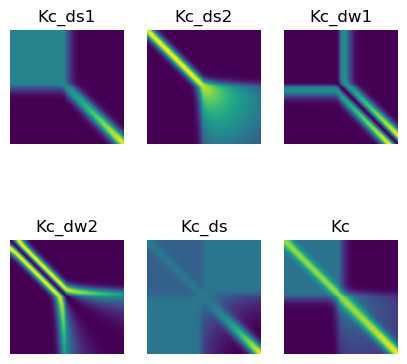

In [6]:
#plot Kcom_ds
x=tr.tensor(x_grid,dtype=tr.float32)
s1,w1,s2,w2,scale,sp =  1.0,.1,1.0,2.2,1.0,.1
fig, ax= plt.subplots(2,3,figsize=(5, 5))
Ks1=Kcom_ds1(x,s1,w1,s2,w2,scale,sp)
Kw1=Kcom_dw1(x,s1,w1,s2,w2,scale,sp)
Ks2=Kcom_ds2(x,s1,w1,s2,w2,scale,sp)
Kw2=Kcom_dw2(x,s1,w1,s2,w2,scale,sp)
Ks=Kcom_ds(x,s1,w1,s2,w2,scale,sp)
K=splitRBFkerMat(x,s1,w1,s2,w2,scale,sp)
dK=[Ks1,Kw1,Ks2,Kw2,Ks,K]
#title of the plot

ax[0,0].imshow(Ks1.detach().numpy())
ax[0,0].set_title('Kc_ds1')
ax[0,1].imshow(Ks2.detach().numpy())
ax[0,1].set_title('Kc_ds2')
ax[0,2].imshow(Kw1.detach().numpy())
ax[0,2].set_title('Kc_dw1')
ax[1,0].imshow(Kw2.detach().numpy())
ax[1,0].set_title('Kc_dw2')
ax[1,1].imshow(Ks.detach().numpy())
ax[1,1].set_title('Kc_ds')
ax[1,2].imshow(K)
ax[1,2].set_title('Kc')

#erase scale in axes
for i in range(2):
    for j in range(3):
        ax[i,j].axis('off')

In [392]:

#take time 
start = time.time()
x=tr.tensor(x_grid,dtype=tr.float32)
print(DPDFnormed(x,1.,1.)[1].shape)
end = time.time()
print(end-start)

torch.Size([256])
0.001970052719116211


In [234]:
greek_letterz=[chr(code) for code in range(915,970)]
print(greek_letterz)

['Γ', 'Δ', 'Ε', 'Ζ', 'Η', 'Θ', 'Ι', 'Κ', 'Λ', 'Μ', 'Ν', 'Ξ', 'Ο', 'Π', 'Ρ', '\u03a2', 'Σ', 'Τ', 'Υ', 'Φ', 'Χ', 'Ψ', 'Ω', 'Ϊ', 'Ϋ', 'ά', 'έ', 'ή', 'ί', 'ΰ', 'α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω']


In [1]:
import GP

In [1141]:

# General GP V1.1
# I have modified the class to include the possibility of a prior in the second level of inference
class GaussianProcess():
    def __init__(self,x_grid,V,Y,Gamma,name,Pd= lambda x : 2.*(1.-x) ,Ker = lambda x: tr.outer(x,x),**args):
        self.name=name
        self.x_grid = tr.tensor(x_grid)
        self.N = x_grid.shape[0]
        self.V = tr.tensor(V)
        self.Y = tr.tensor(Y)
        self.Gamma = tr.tensor(Gamma) # data covariance
        self.Pd = Pd # the default model function. It must work in torch for training?
        self.Ker = Ker # the Kernel
        self.pd_args = tuple([tr.tensor([a]) for a in args["Pd_args"]])
        self.ker_args = tuple([tr.tensor([a]) for a in args["Ker_args"]])
        self.input_pd_args = self.pd_args
        self.input_ker_args = self.ker_args

        #define uncertainty in the data
        self.Npd_args = len(self.pd_args)
        self.Nker_args = len(self.ker_args)
        
    def ComputePosterior(self): # computes the covariance matrix of the posterior
        K = self.Ker(self.x_grid,*self.ker_args)
        Pd = self.Pd(self.x_grid,*self.pd_args)
        Chat = self.Gamma + self.V@K@self.V.T
        iChat = tr.linalg.inv(Chat)
        VK = self.V@K
        #print(K)
        self.CpMat = K - VK.T@iChat@VK
        self.Pm = Pd +VK.T@iChat@(self.Y-self.V@Pd)
        return self.Pm,self.CpMat
    
    def nucovariance(self):
        #define nu grid for the covariance matrix
        nu=tr.linspace(0,100,10000)
        #compute the covariance matrix in x
        K = self.Ker(self.x_grid,*self.ker_args)
        return K
        
    #define the pdf as a function of kernel and parameters
    def posteriorpdf(self,p_x,k_x):
        # p = [a,b,sig,w]
        pd_args = tuple(p_x)
        k_args = tuple(k_x)
        K = self.Ker(self.x_grid,k_args)
        Pd = self.Pd(self.x_grid,pd_args)
        Chat = self.Gamma + self.V@K@self.V.T
        iChat = tr.linalg.inv(Chat)
        VK = self.V@K
        #Posterior covariance
        Cov = K - VK.T@iChat@VK
        Cov = (Cov + Cov.T)/2+1e-6*tr.eye(Cov.shape[0])
        Mean = Pd +VK.T@iChat@(self.Y-self.V@Pd)
        return tr.distributions.multivariate_normal.MultivariateNormal(Mean,Cov)

    #This also defines the likelihood in the second level of inference
    def nlpEvidence(self,p_x,k_x):
        # p = [a,b,sig,w]
        pd_args = tuple(p_x)
        k_args = tuple(k_x)
        K = self.Ker(self.x_grid,*k_args)
        Pd = self.Pd(self.x_grid,*pd_args)
        Chat = self.Gamma + self.V@K@self.V.T
        iChat = tr.linalg.inv(Chat)
        self.Chat = Chat
        self.iChat = iChat
        #print(Y,self.V,Pd)
        D = self.Y - self.V@Pd
        # no need for D.T@iChat@D D.@iChat@D does the job...
        sign,logdet = tr.linalg.slogdet(Chat)
        nlp = 0.5*(D@iChat@D + sign*logdet)
        return nlp
    
    def train(self,Nsteps=100,lr=0.4,mode="kernel"):
        #set initial values of the parameters
        p_x=tr.tensor(self.pd_args ,requires_grad=True)
        k_x=tr.tensor(self.ker_args,requires_grad=True)
        optim = tr.optim.Adam([p_x,k_x], lr=lr) # train everything
        if mode=="kernel" :
            optim = tr.optim.Adam([k_x], lr=lr) # train only kernel
            print("Training kernel only")
        elif mode=="mean" :
            print("Training mean only")
            optim = tr.optim.Adam([p_x], lr=lr) # train only default model
        else:
            print("Training everything")
        losses = []
        for i in range(Nsteps):
            optim.zero_grad()
            loss = self.nlpEvidence(p_x,k_x)
            if loss.isnan():
                print("NaN detected")
                break
            loss.backward()
            optim.step()
            losses.append(loss.detach().item()+self.Gamma.shape[0]/2.0*np.log(2.0*np.pi))
        self.pd_args=tuple(p_x.detach())
        self.ker_args=tuple(k_x.detach())
        return losses
    
    def prior2ndlevel(self,mode,Nsam,mean,sigma,nonzero=tr.tensor([1,2])):
        #p_x=tr.tensor(self.pd_args)
        #k_x=tr.tensor(self.ker_args)
        p_x=mean[:self.Npd_args]
        k_x=mean[self.Npd_args:self.Npd_args+self.Nker_args]
        self.mode=mode
        self.nonzero=nonzero
        #For the case of the jacobi kernel we have to add a contraint in the interval 
        #the diagonal depends on the kernel type
        sigma_pd = tr.diag(sigma[:self.Npd_args])
        sigma_ker = tr.diag(sigma[self.Npd_args:self.Nker_args+self.Npd_args])
        #tr.tensor([10.0,0.5,2.0,2.0]) #This works for jacobi
        #tr.diag(tr.tensor([10.0,10.0])) #This works for RBF
        #covprior_pd = tr.diag(covprior[:self.Npd_args])
        #covprior_ker = tr.diag(covprior[self.Npd_args:self.Nker_args+self.Npd_args])
        #sigma_ker = tr.diag(tr.tensor([10.0,4.5,5.0,5.0,10.0,5.0]))
        
        #self.prior_ker = tr.distributions.MultivariateNormal(k_x,covariance_matrix=covprior_ker[:self.Nker_args,:self.Nker_args])
        #self.prior_ker =  tr.distributions.MultivariateNormal(k_x,covprior_ker[:self.Nker_args,:self.Nker_args])
        #sigma_pd = tr.diag(tr.tensor([2.0,3.0]))

        self.prior_pd =[]
        self.prior_ker=[]
        for i in range(self.Npd_args):
            self.prior_pd.append(lognormal(p_x[i],sigma_pd[i,i],1.0))
        for i in range(self.Nker_args):
            if i in nonzero-1:
                self.prior_ker.append(lognormal(k_x[i],sigma_ker[i,i],0.0))
            else:#gaussian or other
                self.prior_ker.append(tr.distributions.Normal(k_x[i],sigma_ker[i,i]))


        #sampling from the prior, however this is not important for now
        sampleab =  tr.distributions.MultivariateNormal(p_x,covariance_matrix=sigma_pd[0:self.Npd_args,0:self.Npd_args])
        trace_ab= sampleab.sample((Nsam,))
        sampleker =  tr.distributions.MultivariateNormal(k_x,covariance_matrix=sigma_ker[:self.Nker_args,:self.Nker_args])
        trace_ker = sampleker.sample((Nsam,))
        
        if self.mode=="kernel":
            self.traceprior = trace_ker
        elif self.mode=="mean":
            self.traceprior = trace_ab
        else:
            traceprior = tr.cat((trace_ab.T,trace_ker.T)).T
        self.traceprior= traceprior

    def hyperparametersvalues(self,burn=100,set="sampling"):
        #Mean and standard deviation of the hyperparameters
        if set=="sampling":
            self.pd_args= tuple(tr.mean(self.trace[burn:,:2],dim=0).detach())
            self.pd_std= tuple(tr.std(self.trace[burn:,:2],dim=0).detach())
            self.ker_args= tuple(tr.mean(self.trace[burn:,2:],dim=0).detach())
            self.ker_std= tuple(tr.std(self.trace[burn:,2:],dim=0).detach())
        elif set=="original":
            self.pd_args= self.input_pd_args
            self.ker_args= self.input_ker_args

    def post2levelpdf(self,X):

        p_x=tr.tensor(self.pd_args).clone().detach()
        k_x=tr.tensor(self.ker_args).clone().detach()
        prior=1.0
        if self.mode=="kernel":
            kx=X.clone()
            likelihood = tr.exp(-self.nlpEvidence(p_x,kx))
            for i in range(self.Nker_args):
                if i in self.nonzero-1:
                    prior*= self.prior_ker[i].pdf(kx[i])
                else:
                    prior*= tr.exp(self.prior_ker[i].log_prob(kx[i]))
        elif self.mode=="mean":
            px=X.clone()
            likelihood = tr.exp(-self.nlpEvidence(px,k_x))
            for i in range(self.Npd_args):
                prior*= self.prior_pd[i].pdf(px[i])
            #prior= self.prior_pd.pdf(px)
            #prior= tr.exp(self.prior_pd.log_prob(px))
        else:# all hyperparameters
            px = X[:self.Npd_args]
            kx = X[self.Npd_args:self.Nker_args+self.Npd_args]
            likelihood = tr.exp(-self.nlpEvidence(px,kx))
            prior=1
            for i in range(self.Nker_args):
                #print(prior,i,"kernel")
                if i in self.nonzero-1:
                    prior*= self.prior_ker[i].pdf(kx[i])
                else:
                    prior*= tr.exp(self.prior_ker[i].log_prob(kx[i]))
                #print(prior)
            for i in range(self.Npd_args):
                #print(prior,i,"Pd")
                prior*= self.prior_pd[i].pdf(px[i])
            self.prior= prior
            #prior = tr.exp(self.prior_ker.log_prob(kx)+self.prior_pd.log_prob(px))
        return likelihood*prior#*10000000000000
    def nlogpost2levelpdf(self,X):
        #print(self.post2levelpdf(X))
        return -tr.log(self.post2levelpdf(X))
    def gradlogpost2levelpdf(self,X):
        px=X[:self.Npd_args]
        px=tuple(px)
        kx=X[self.Npd_args:self.Nker_args+self.Npd_args]
        kx=tuple(kx)
        dK_ds1 = Kcom_ds1(self.x_grid,*kx).type(tr.float64)
        dK_dw1 = Kcom_dw1(self.x_grid,*kx).type(tr.float64)
        dK_ds2 = Kcom_ds2(self.x_grid,*kx).type(tr.float64)
        dK_dw2 = Kcom_dw2(self.x_grid,*kx).type(tr.float64)
        dK_ds = Kcom_ds(self.x_grid,*kx).type(tr.float64)
        
        K = self.Ker(self.x_grid,*kx)
        Pd = self.Pd(self.x_grid,*px)
        Chat = self.Gamma + self.V@K@self.V.T
        iChat = tr.linalg.inv(Chat)
        #print(Y,self.V,Pd)
        D = self.Y - self.V@Pd


        DP=DPDFnormed(self.x_grid,*px)
        grad=[]
        for dP in DP:
            grad.append(-(self.V@dP.type(tr.float64)@iChat@D))#+self.D@self.iChat@dP.type(tr.float64)@self.V))

        dK = [dK_ds1,dK_dw1,dK_ds2,dK_dw2,dK_ds]
        self.alp= iChat@D
        for i in range(self.Nker_args):
            grad.append(0.5*(self.alp.T@self.V@dK[i].type(tr.float64)@self.V.T@self.alp)-0.5*tr.trace(iChat@self.V@dK[i].type(tr.float64)@self.V.T))
        
        return tr.tensor([grad])


    #this samples the hyperparameters in the second level of inference
    def sample_HMC(self,current_q,Nsamples,L,eps,mode,diagonal=0.01*tr.tensor([0.2,1.0,1.0,1.0,0.01,1.1,0.1])):
        #set initial values of the parameters for each kernel 
        self.trace = tr.zeros((Nsamples,current_q.shape[0]))
        #self.prior2level(mode,Nsamples,covprior) #If we insert this in here we do not have to select the covariance
        for i in range(Nsamples):
            self.trace[i] = current_q
            new_q = HMC(self.nlogpost2levelpdf,eps,L,current_q,diagonal)
            current_q = new_q.clone().detach()
            if  (self.trace[i-1]==self.trace[i]).sum().item() and (self.trace[i]==self.trace[i-1000]).sum().item() and i>1002:
                print("1000 repeated samples",i)
                break

            
        if mode=="kernel" :
            print("Sampling kernel-hyperparameters only")
            
        elif mode=="mean" :
            print("Sampling mean-hyperparameters only")

        else:
            print("Sampling everything")



In [1054]:
x

tensor([9.9999999600419720e-13, 1.2207147185444578e-12, 1.4901443794179681e-12,
        1.8190412284097013e-12, 2.2205301833388980e-12, 2.7106338007509834e-12,
        3.3089106541567270e-12, 4.0392359595964322e-12, 4.9307545893495508e-12,
        6.0190446377061946e-12, 7.3475357742491809e-12, 8.9692454852130510e-12,
        1.0948889364592596e-11, 1.3365470188930750e-11, 1.6315426440427494e-11,
        1.9916479923609565e-11, 2.4312340335397309e-11, 2.9678429852575405e-11,
        3.6228898353529715e-11, 4.4225147849408231e-11, 5.3986287662510790e-11,
        6.5901853418814937e-11, 8.0447364048108483e-11, 9.8203278842134978e-11,
        1.1987819070746752e-10, 1.4633706746369768e-10, 1.7863580059618300e-10,
        2.1806334515872550e-10, 2.6619312309961174e-10, 3.2494587576259448e-10,
        3.9666619988665275e-10, 4.8421627818484581e-10, 5.9108989924894217e-10,
        7.2155215136149309e-10, 8.8080931437417576e-10, 1.0752168044803057e-09,
        1.3125329711982658e-09, 1.602228

In [295]:
x=tr.tensor(x_grid,dtype=tr.float64)
Pd_args=(0.2,1.0)
DP_da,DP_db=DPDFnormed(x,*Pd_args)
myGP0.V@DP_da.type(tr.float64)

tensor([3.4924205749404864, 0.0000000000000000, 2.7330300153605971,
        1.6804211005733016, 1.4795423898125097, 1.4910909213030774,
        1.3654366634826123, 1.3386005821938625], dtype=torch.float64)

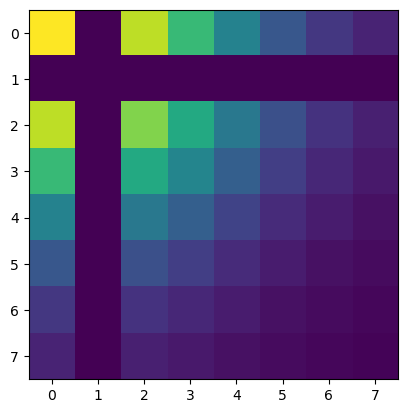

In [575]:
Knu=myGP0.V.type(tr.float32)@Ks1@myGP0.V.T.type(tr.float32)
plt.imshow(Knu[0:,0:])


## check this 

In [8]:
mean= tr.tensor([2.10])
cov = tr.tensor([1.1])
dist=[]
for i in range(1):
    dist.append(lognormal(mean,cov,shift=1.0))
    print(dist[i].pdf(tr.tensor([0.1])),dist[i].pdf(tr.tensor([0.1])))

tensor([0.0626]) tensor([0.0626])


In [15]:
#dist1=multivariategaussiantorch(mean,cov)
#print(dist1.pdf(tr.tensor([0.1,0.0])),tr.exp(dist.log_prob(tr.tensor([0.1,0.0]))),dist.log_prob(tr.tensor([0.1,0.0])))
#print args
#sample from the prior
def UU(xx):
    return -tr.log(dist[0].pdf(xx))

sampler=HMC_sampler(UU,diagonal=tr.tensor([1.0]))
sampler.q0=tr.tensor([0.1],requires_grad=True)
qs,ps,H=sampler.sample(tr.tensor([0.1]),10000,1/15,15)


rejected


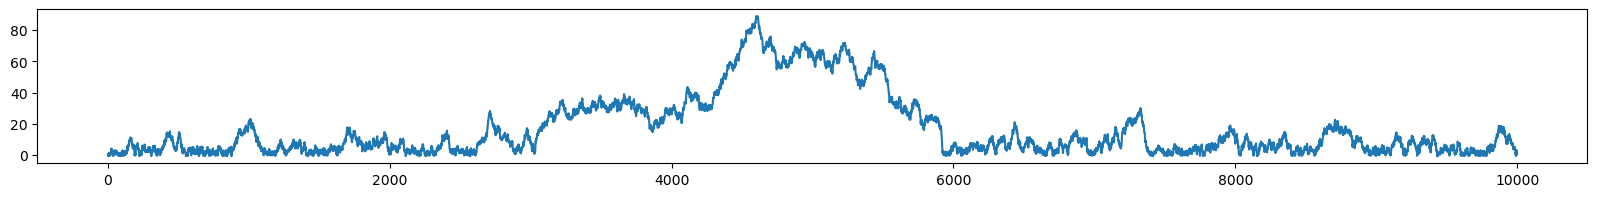

In [11]:
#plot qs
fig, ax = plt.subplots(1,figsize=(20, 2))
plt.plot(qs[:].detach().numpy())
plt.show()

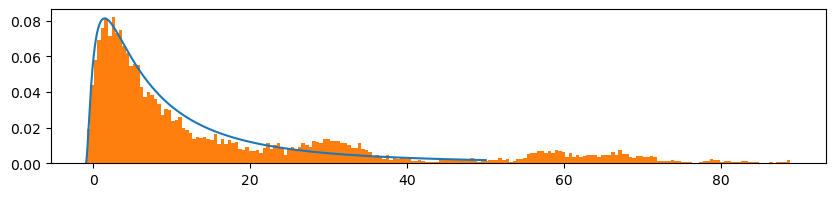

In [14]:
#histogram
qs1=qs[:].detach().numpy()
x = tr.linspace(-1.0,50,1000)
fig, ax = plt.subplots(1,figsize=(10, 2))
pdfs=tr.zeros(x.shape[0])
for i in range(x.shape[0]):
    pdfs[i]=dist[0].pdf(x[i])
ax.plot(x.T,pdfs)
ax.hist(qs1.T[qs1.T>-dist[0].shift],bins=200,density=True)
plt.show()

In [800]:
if (x<tr.ones(x.shape[0])*1e-6).any():
    print("yes")

yes


In [17]:
#TESTED VALUES FOR HMC SAMPLING
#set up for rbf kernel 'all' (4param)
#Momentum
diagonalrbf=0.06*tr.tensor([0.01,1.0,10.0,1.0])
N=800

#point of initial guess
Xrbf=tr.tensor([ 0.0000,  2.5000, 5.0000,  1.6000])
Xrbf2=tr.tensor([-0.1558,  2.1393,  3.9630,  1.3488])
Xrbf3=tr.tensor([-0.1782,  1.9628,  4.8164,  1.3194])

#set up for the jacobi kernel-mode(4param) all-mode (6param)
#Momentum
diagonaljac=0.00001*tr.tensor([1.0,1.0,1.0,1.0])
diagonaljacfull=0.00001*tr.tensor([100.0,100.0,1.0,1.0,1.0,1.0])
diajacfull=0.00001*tr.tensor([1.0,1.0,1.0,1.0,1.0,1.0])
N=1000

#point of initial guess
Xjac=tr.tensor([1.5,0.5,0.01,0.1])
X1=tr.tensor([1.9254, 1.3573, 0.6834, 0.7607])
X2=tr.tensor([2.1332, 1.1216, 0.3113, 0.9068])
#full jacobi+Pd


X2full = tr.tensor([0.3113, 0.9068, 2.1332, 1.1216, 0.3113, 0.9068])


#set up for the split-rbf kernel-mode(5param) all-mode(7param)
#Momentum
diagonal=0.01*tr.tensor([0.2,1.0,1.0,1.0,1.0,1.1,0.1])
#point of initial guess
Xmagic=tr.tensor([ 0.3080,  0.0850,  9.1361,  3.0805, 14.1310,  3.1610,  0.1629])#,  1.4058])
Xmagic1=tr.tensor([ 0.8853,  0.3546,  9.3920,  2.1064, 14.4940,  3.6928,  1.2163])#,  1.4058])
Xmagic2=tr.tensor([ 0.3500,  0.4024, 10.1177,  1.9934, 16.3101,  4.6692,  1.2078])#,  1.3786])

In [16]:
#set up input data
def preparedata(i,nu,rMj,rMe,rM):
    #prepare the data
    Nnu = nu.shape[1]
    CovD= np.corrcoef(rMj[:,:,i-1].T)#*(rMj[:,:,i-1].T.shape[0]-1)
    CovD =tr.tensor( (CovD + CovD.T)/2)
    M = rM.T[i]
    eM = rMe.T[i]
    n = nu.T[i]
    Nx=256
    x_grid = np.concatenate((np.logspace(-12,-1,np.int32(Nx/2)),np.linspace(0.1+1e-4,1-1e-12,np.int32(Nx/2))))
    fe = FE2_Integrator(x_grid)
    lam = 1e-5   # soften the constrants
    lam_c = 1e-5
    B0 = fe.set_up_integration(Kernel=lambda x: 1)
    B1 = np.zeros_like(B0) 
    B1[-1] = 1.0 # x=1 is at the end...
    n # is the nu values at current z
    B = np.zeros((n.shape[0],Nx))
    for k in np.arange(n.shape[0]):
        B[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(n[k]*x))
    V = np.concatenate((B0[np.newaxis,:],B1[np.newaxis,:],B))
    Gamma = np.zeros((V.shape[0],V.shape[0]))
    Gamma[0,0] = lam
    Gamma[1,1] = lam_c
    Gamma[2:,2:] = CovD
    Y = np.concatenate(([1,0],M))
    return x_grid,V,Y,Gamma

# How to use it?
### Construct the GP object and prepare the data (jacobi)

In [ ]:
fits=[]
for i in range(nu.shape[1]):
    x_gri0,V0,Y0,Gamma0 = preparedata(i,nu,rMj,rMe,rM)
    myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z={i}",Pd=simplePDFnormed, Ker=jacobi,Pd_args=(-0.2,2.0),Ker_args=(0.9,0.8,1.01,2.1))
    fits.append(myGP0)
    print(f"z={i}a done")

## Sampling phase

In [ ]:
#sample the models to fit number of samples should be increased from N=10000(306 minutes) to N=1000000
Nsamples=10000
for i in range(nu.shape[1]):
    print(fits[i].name)
    fits[i].prior2level("all",Nsamples,5*tr.tensor([10.0,4.5,5.0,5.0,10.0,5.0]))
    fits[i].sample_HMC(X2full+0.1*tr.rand(X2full.shape[0]),diagonal=diajacfull*1000,mode="all",L=800,Nsamples=Nsamples,eps=1.0/1000)
    #plotrace(fits[i].trace[:],0,kernel='jacobifull')

In [ ]:
plotrace(fits[0].trace[:],0,kernel='jacobifull')

### Run again data with broken chains changing parameters.
0-4, 9-11

In [ ]:
for i in range(4):
    print(fits[i].name)
    fits[i].prior2level("all",Nsamples,10*tr.tensor([10.0,4.5,5.0,5.0,10.0,5.0]))
    fits[i].sample_HMC(X2full+0.1*tr.rand(X2full.shape[0]),diagonal=diajacfull*1000,mode="all",L=600,Nsamples=Nsamples,eps=1.0/1000)
    #9-11 fit
for i in range(9,11):
    print(fits[i].name)
    fits[i].prior2level("all",Nsamples,10*tr.tensor([10.0,4.5,5.0,5.0,10.0,5.0]))
    fits[i].sample_HMC(X2full+0.1*tr.rand(X2full.shape[0]),diagonal=diajacfull*1000,mode="all",L=600,Nsamples=Nsamples,eps=1.0/1000)

In [ ]:
plotrace(fits[3].trace[:],0,kernel='jacobifull')

In [ ]:
#run fits for 0,3
for i in [0,3]:
    print(fits[i].name)
    fits[i].prior2level("all",Nsamples,10*tr.tensor([10.0,4.5,5.0,5.0,10.0,5.0]))
    fits[i].sample_HMC(X2full+0.1*tr.rand(X2full.shape[0]),diagonal=diajacfull*1000,mode="all",L=500,Nsamples=Nsamples,eps=1.0/1000)

In [ ]:
plothist(fits[0].trace[:],fits[0].traceprior[:],0,kernel='jacobifull')

In [ ]:
print("Hyper parameters after sampling: (alpha,beta,s,t,a,b)=\n")
for i in range(12):
    print(fits[i].name)
    fits[i].hyperparametersvalues(burn=100,set="sampling")
    print(fits[i].pd_args,fits[i].ker_args)
print(fits[0].input_pd_args,fits[0].input_ker_args)

In [352]:
fits[0].pd_args, fits[0].ker_args =(tr.tensor(0.1529), tr.tensor(2.0441)), (tr.tensor(0.1859), tr.tensor(0.2119), tr.tensor(2.1580), tr.tensor(2.5278))
fits[1].pd_args, fits[1].ker_args =(tr.tensor(-0.1316), tr.tensor(2.2837)), (tr.tensor(0.3256), tr.tensor(0.2753), tr.tensor(2.4580), tr.tensor(2.5541))
fits[2].pd_args, fits[1].ker_args =(tr.tensor(-0.2695), tr.tensor(2.2418)), (tr.tensor(0.2156), tr.tensor(0.2578), tr.tensor(1.9934), tr.tensor(2.8703))
fits[3].pd_args, fits[1].ker_args =(tr.tensor(-0.2805), tr.tensor(1.9204)), (tr.tensor(0.1427), tr.tensor(0.2231), tr.tensor(1.8206), tr.tensor(2.5751))
fits[4].pd_args, fits[1].ker_args =(tr.tensor(-0.1735), tr.tensor(2.0618)), (tr.tensor(0.2994), tr.tensor(0.2097), tr.tensor(2.1905), tr.tensor(2.7003))
fits[5].pd_args, fits[1].ker_args =(tr.tensor(-0.0845), tr.tensor(2.0747)), (tr.tensor(0.2947), tr.tensor(0.3065), tr.tensor(2.0054), tr.tensor(2.6255))
fits[6].pd_args, fits[1].ker_args =(tr.tensor(0.0294), tr.tensor(2.2276)),(tr.tensor(0.3321), tr.tensor(0.3312), tr.tensor(2.2596), tr.tensor(2.4622))
fits[7].pd_args, fits[1].ker_args =(tr.tensor(0.0948), tr.tensor(2.2892)), (tr.tensor(0.3234), tr.tensor(0.3158), tr.tensor(2.1024), tr.tensor(2.5864))
fits[8].pd_args, fits[1].ker_args =(tr.tensor(0.1421), tr.tensor(2.3843)), (tr.tensor(0.2434), tr.tensor(0.3371), tr.tensor(1.9662), tr.tensor(2.6540))
fits[9].pd_args, fits[1].ker_args =(tr.tensor(0.1802), tr.tensor(2.4311)), (tr.tensor(0.4163), tr.tensor(0.2113), tr.tensor(2.3659), tr.tensor(2.8418))
fits[10].pd_args, fits[1].ker_args = (tr.tensor(0.1509), tr.tensor(2.4128)), (tr.tensor(0.2428), tr.tensor(0.2172), tr.tensor(2.3488), tr.tensor(2.8636))
fits[11].pd_args, fits[1].ker_args = (tr.tensor(0.1185), tr.tensor(2.3149)), (tr.tensor(0.2991), tr.tensor(0.1322), tr.tensor(2.2870), tr.tensor(2.6585))




In [ ]:
#Plot the data n vs rM and error bars eM
fig, ax= plt.subplots(2,figsize=(10, 10))
ax[0].set_title("Reconstructed PDF with sampling (Posterior)")
ax[1].set_title("Reconstructed ITD with sampling (nu-space)")
col=['red','blue','green','pink','black','orange','purple','brown','cyan','magenta','yellow','grey']
for i in range(0,12):
    fe = FE2_Integrator(x_grid)
    p,Cp = fits[i].ComputePosterior()
    Cp = 0.5*(Cp+Cp.T) +1e-7*tr.eye(Cp.shape[0])
    Mc=tr.distributions.MultivariateNormal(p,covariance_matrix=Cp)
    #plot the data
    pdfMc = Mc.sample((100,))
    ax[0].plot(x_grid,pdfMc.T.numpy(),color=col[i],alpha=0.1)
    ax[0].plot(x_grid,fits[i].Pd(fits[i].x_grid,*fits[i].pd_args).numpy(),label='z='+str(i+1),color=col[i])
    ax[0].legend()
    ax[0].set_ylim([-0.1,4])
    #ax[0].ylim([-0.1,4])
    nn = np.linspace(0,15,128)
    iB = np.zeros((nn.shape[0],Nx))
    for k in range(nn.shape[0]):
        iB[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))
    ttQ = pdfMc.numpy()@iB.T
    mttQ = ttQ.mean(axis=0)
    ax[1].plot(nn,ttQ.T,color=col[i],alpha=0.1)
    ax[1].plot(nn,mttQ,color=col[i])
    ax[1].legend()
    plt.errorbar(nu.T[i],rM.T[i],yerr=rMe.T[i],fmt='.',alpha=0.5,label='z='+str(i+1),color=col[i])
    plt.legend()

## Combined Kernel  

In [20]:
fits_comb=[]
for i in range(0,nu.shape[1]):
    x_gri0,V0,Y0,Gamma0 = preparedata(i,nu,rMj,rMe,rM)
    myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z={i+1}a",Pd=simplePDFnormed, Ker=splitRBFkerMat,Pd_args=(0.2,1.0),Ker_args=(10.0,1.1,8.0,1.1,9.0))
    fits_comb.append(myGP0)
    print(fits_comb[i].name, "done")

z=1a done
z=2a done
z=3a done
z=4a done
z=5a done
z=6a done
z=7a done
z=8a done
z=9a done
z=10a done
z=11a done
z=12a done


In [1292]:
#Pd_args=(0.2,1.0),Ker_args=(10.0,1.1,8.0,1.1,9.0)
myGP0.prior2ndlevel("all",1000,mean=tr.tensor([-0.2,1.5,1.0,.1,1.0,2.2,1.0]),sigma=tr.tensor([1.0,0.2,1.0,10.1,1.0,2.2,6.0]),nonzero=tr.tensor([1,3]))

In [1268]:
myGP0.prior_ker[0]

In [1269]:
uwu=tr.tensor([0.2,1.0,1.0,1.1,8.0,1.1,9.0])
px=tr.tensor([0.2,1.0])
kx=tr.tensor([1.0,1.1,8.0,1.1,9.0])
myGP0.nlpEvidence(px,kx)

tensor(-0.2933043545845825, dtype=torch.float64)

In [1270]:
start = time.time()
x=tr.tensor(x_grid,dtype=tr.float32)
res=myGP0.gradlogpost2levelpdf(tr.tensor([0.2,1.0,1.0,1.1,8.0,1.1,9.0]))
end = time.time()
print(end-start,res)

0.04429292678833008 tensor([[ 0.2298801827069515, -0.1226034064163535, -1.1721401720920799,
          0.1329575278490023, -0.1361167845809919, -0.1931016629165164,
          0.0515728576137479]], dtype=torch.float64)


In [1119]:
def Evi(X):
    px=X[:2]
    kx=X[2:]
    return myGP0.nlpEvidence(px,kx)

In [1271]:

#time the gradient
start = time.time()
resa=autograd(Evi,tr.tensor([0.2,1.0,1.0,1.1,8.0,1.1,9.0]))
end = time.time()
print(end-start,resa)

0.10971689224243164 tensor([ 0.2298801839351654, -0.1226033866405487,  1.1721401214599609,
        -0.1329575330018997,  0.1361167877912521,  0.1931016594171524,
        -0.0515728592872620])


In [1289]:
myGP0.prior_pd[1].mu

tensor(1.5000000000000000)

In [1187]:
myGP0.post2levelpdf(tr.tensor([1.0,01.1,10.0,01.1,8.0,.1,9.0])), myGP0.nlogpost2levelpdf(tr.tensor([1.0,01.1,10.0,01.1,8.0,.1,9.0])), myGP0.nlogpost2levelpdf(Xmagic)

(tensor(4.5463072285377951e-43, dtype=torch.float64),
 tensor(97.4968436934287297, dtype=torch.float64),
 tensor(inf, dtype=torch.float64))

In [ ]:
tr.log(tr.tensor([-4.0340107857307527e-15+1e-12]))

In [1293]:
diagonal
momentum=tr.tensor([1.0,0.1,2.1,1.0,.1,1.0,1.0])

In [1294]:
GPsampler=HMC_sampler(myGP0.nlogpost2levelpdf,diagonal=momentum)

In [1295]:
#create a tensor with random values from 0,10
rand=tr.rand(7)*5
GPsampler.q0=rand
print(GPsampler.q0)

tensor([2.2652392387390137, 4.8137855529785156, 4.0454010963439941,
        4.0368580818176270, 4.7809638977050781, 0.2142500877380371,
        4.3270096778869629])


In [1296]:
GPsampler.q0=rand

In [1297]:
tr.isinf(myGP0.nlogpost2levelpdf(GPsampler.q0)).any()

tensor(False)

In [1231]:
GPsampler.q0[2]

tensor(1.5831425189971924)

In [1224]:
tr.log(tr.exp(myGP0.prior_ker[1].log_prob(GPsampler.q0[2])))

tensor(-inf)

In [1291]:
myGP0.prior_ker

 Normal(loc: 0.10000000149011612, scale: 10.100000381469727),
 Normal(loc: 2.200000047683716, scale: 2.200000047683716),
 Normal(loc: 1.0, scale: 10.0)]

In [708]:
myGP0.prior_ker

 Normal(loc: 1.0, scale: 0.5),
 Normal(loc: 1.0, scale: 0.5),
 Normal(loc: 1.0, scale: 0.5)]

In [1298]:
traceq,tracep,traceH=GPsampler.sample(rand,1000,1.0/15,15)

rejected
rejected in leapfrog 2
rejected
rejected
rejected
rejected
rejected
rejected in leapfrog 2
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected in leapfrog 2
rejected
rejected
rejected in leapfrog 2
rejected
rejected
rejected
rejected in leapfrog 2
rejected
rejected
rejected in leapfrog 2
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected in leapfrog 2
rejected
rejected
rejected
rejected
rejected in leapfrog 2
rejected
rejected
rejected
rejected
rejected
rejected
rejected in leapfrog 2
rejected in leapfrog 2
rejected in leapfrog 2
rejected
rejected
rejected
rejected
rejected in leapfrog 2
rejected
rejected
rejected in leapfrog 2
rejected in leapfrog 2
rejected
rejected
rejected
rejected
rejected
rejected
rejected
rejected in leapfrog 2
rejected in leapfrog 2
rejected
rejected
rejected in leapfrog 2
rejected in lea

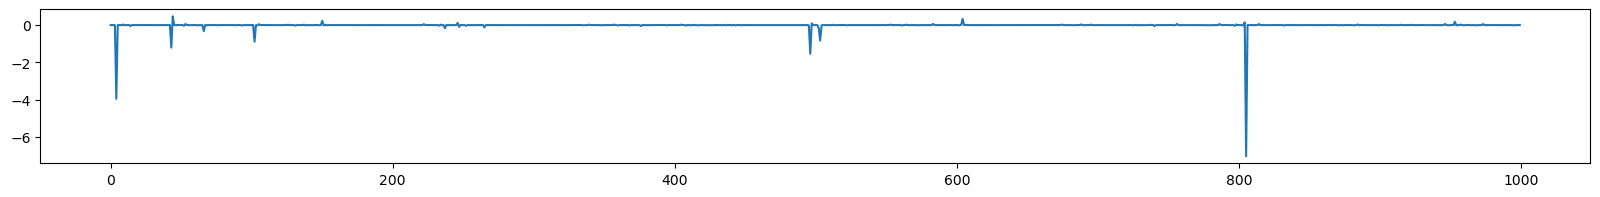

In [1238]:
fig, ax = plt.subplots(1,figsize=(20, 2))

plt.plot(traceH[:])


In [1283]:
myGP0.prior_pd[1].mu

tensor(2.)

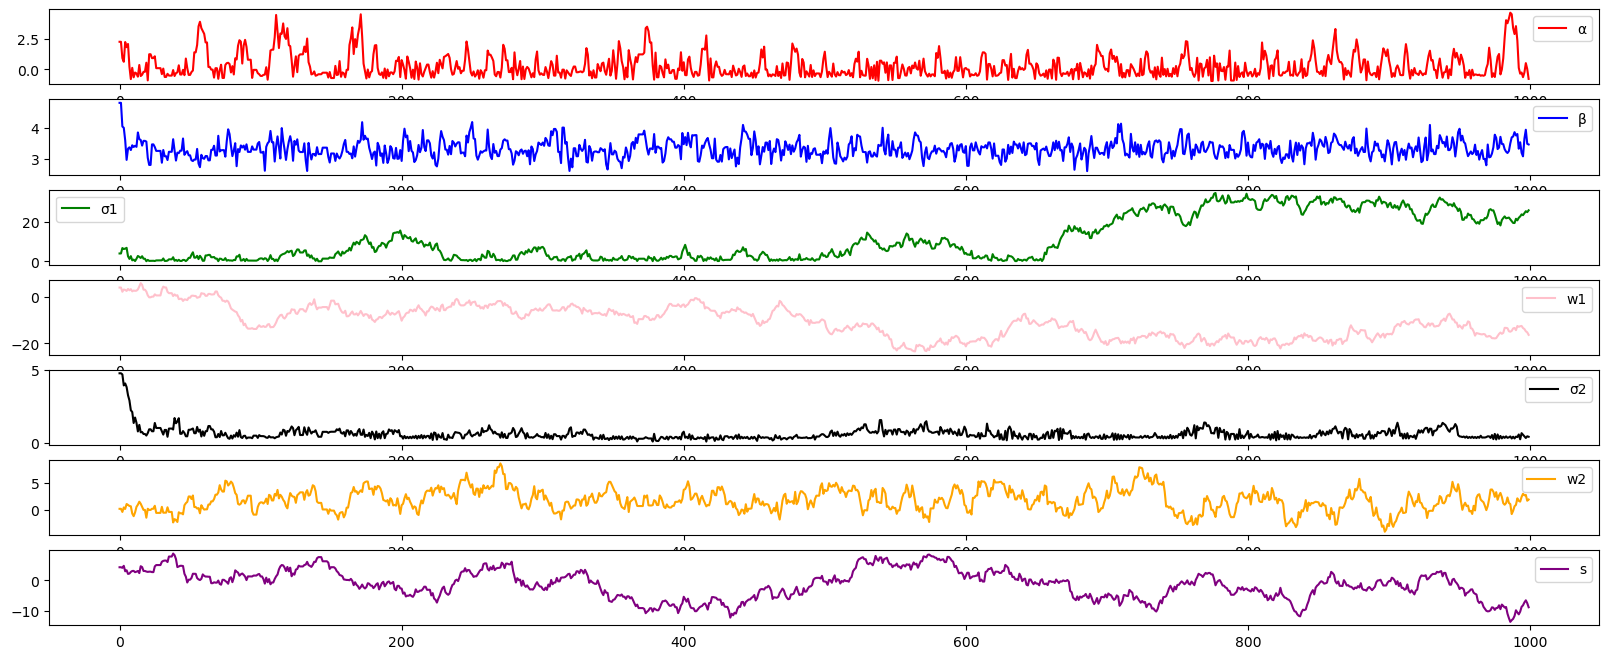

In [1299]:
plotrace(traceq[0:1000],0,kernel='splitrbf')

In [1301]:
traceq.mean(dim=0)

tensor([  0.2494637072086334,   3.3173983097076416,  11.1608657836914062,
        -10.7898120880126953,   0.6031866669654846,   1.8256099224090576,
         -1.3119409084320068])

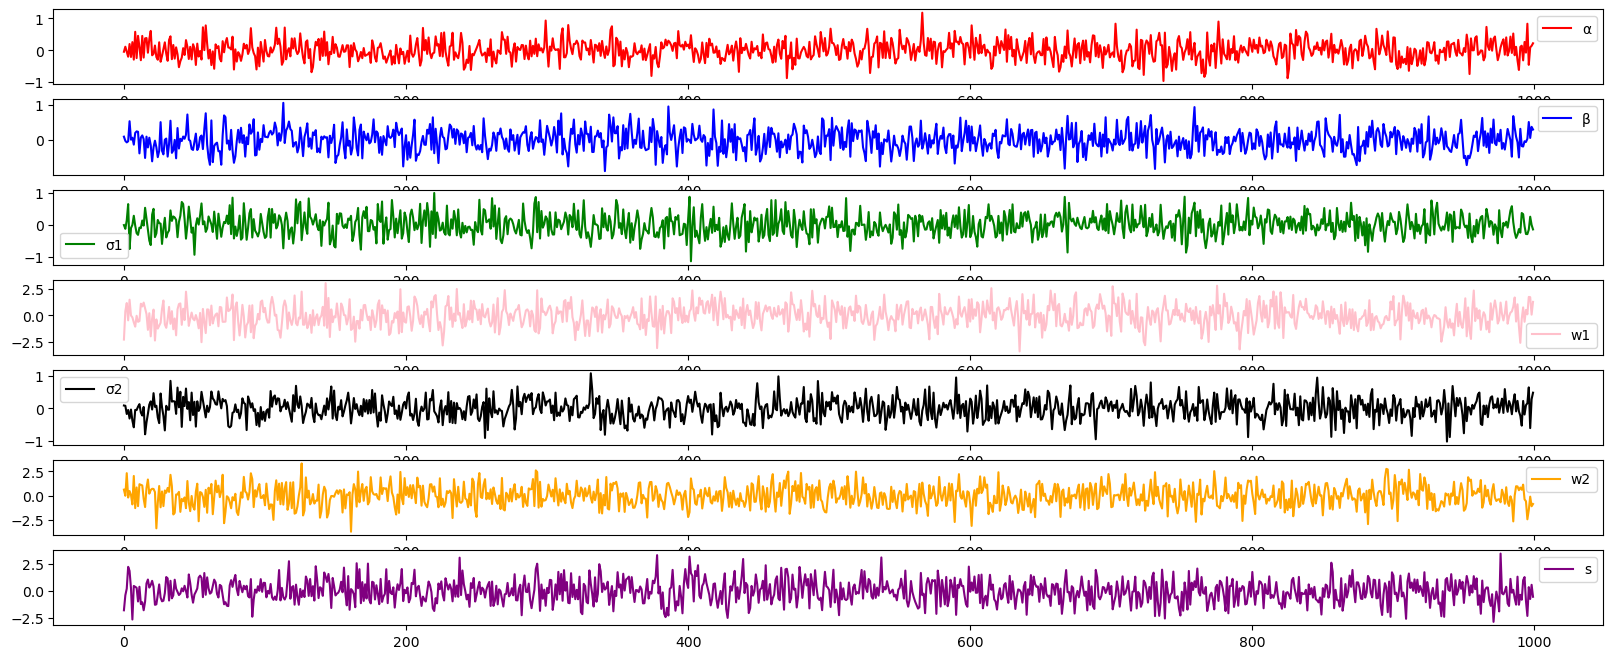

In [753]:
plotrace(tracep[0:1000],0,kernel='splitrbf')

In [665]:
epsT,ΔH=GPsampler.epsilonsqtest(10,1000,10,Xmagic)

tensor([0.1000000014901161, 0.0083333337679505, 0.0043478258885443,
        0.0029411765281111, 0.0022222222760320, 0.0017857142956927,
        0.0014925373252481, 0.0012820513220504, 0.0011235955171287,
        0.0010000000474975]) tensor([  10,  120,  230,  340,  450,  560,  670,  780,  890, 1000],
       dtype=torch.int32)


ValueError: Expected value argument (Tensor of shape ()) to be within the support (Real()) of the distribution Normal(loc: 1.0, scale: 0.5), but found invalid values:
nan

In [ ]:
tr.tensor([  10,  120,  230,  340,  450,  560,  670,  780,  890, 1000])*epsT


In [ ]:
#plot eps, ΔH
plt.title('HMC ε²-test')
plt.scatter(epsT[1:]*epsT[1:],tr.sqrt(ΔH*ΔH)[1:])
#fit a line
m,b = np.polyfit(epsT[1:]*epsT[1:],tr.sqrt(ΔH*ΔH)[1:], 1)
plt.plot(epsT[1:]*epsT[1:], m*epsT[1:]*epsT[1:]+b)
plt.xlabel('ε')
plt.ylabel('ΔH')

plt.show()

In [ ]:
GPsampler.sample_HMC

In [ ]:
#sample the models to fit number of samples should be increased from N=10000(306 minutes) to N=1000000
Nsamples=100
diagonal=tr.tensor([0.01,0.01,1.0,1.0,5.0,1.0,0.050])
#diagonal=tr.ones(Xmagic.shape[0])
for i in range(nu.shape[1]-6):
    print(fits_comb[i].name)
    fits_comb[i].prior2level("all",Nsamples,tr.tensor([5.0,5.0,100.0,100.0,100.0,50.0,5.0]))
    fits_comb[i].sample_HMC(Xmagic2+1.1*tr.rand(Xmagic.shape[0]),diagonal=diagonal,mode="all",L=100,Nsamples=Nsamples,eps=1.0/1000)
    plotrace(fits_comb[i].trace[:],0,kernel='splitrbf')

In [ ]:
for i in range(nu.shape[1]-6,nu.shape[1]):
    print(fits_comb[i].name)
    fits_comb[i].prior2level("all",Nsamples,tr.tensor([5.0,5.0,100.0,100.0,100.0,50.0,5.0]))
    fits_comb[i].sample_HMC(Xmagic2+1.1*tr.rand(Xmagic.shape[0]),diagonal=diagonal,mode="all",L=100,Nsamples=Nsamples,eps=1.0/1000)
    plotrace(fits_comb[i].trace[:],0,kernel='splitrbf')

In [ ]:
diagonal=tr.tensor([0.01,0.01,1.0,0.1,5.0,1.0,0.050])
for i in [1,7,9,11]:
    print(fits_comb[i].name)
    fits_comb[i].prior2level("all",Nsamples,tr.tensor([5.0,5.0,100.0,100.0,100.0,50.0,5.0]))
    fits_comb[i].sample_HMC(Xmagic2+1.1*tr.rand(Xmagic.shape[0]),diagonal=diagonal,mode="all",L=100,Nsamples=Nsamples,eps=1.0/1000)
    plotrace(fits_comb[i].trace[:],0,kernel='splitrbf')

In [ ]:
diagonal=tr.tensor([0.01,0.01,1.0,0.1,5.0,0.5,0.050])
for i in [1]:
    print(fits_comb[i].name)
    fits_comb[i].prior2level("all",Nsamples,tr.tensor([5.0,5.0,100.0,100.0,100.0,50.0,5.0]))
    fits_comb[i].sample_HMC(Xmagic2+1.1*tr.rand(Xmagic.shape[0]),diagonal=diagonal,mode="all",L=100,Nsamples=Nsamples,eps=1.0/1000)
    plotrace(fits_comb[i].trace[:],0,kernel='splitrbf')

In [ ]:
plothist(fits_comb[2].trace[:],fits_comb[2].traceprior[:],0,kernel='splitrbf')

In [ ]:
print("Hyper parameters after sampling: (alpha,beta,s1,w1,s2,w2,sp,scale)=\n")
for i in range(12):
    print(fits_comb[i].name)
    fits_comb[i].hyperparametersvalues(burn=100,set="sampling")
    print(fits_comb[i].pd_args,fits_comb[i].ker_args)
print(fits_comb[0].input_pd_args,fits_comb[0].input_ker_args)

In [ ]:
#Plot the data n vs rM and error bars eM
#fig, ax= plt.subplots(2,figsize=(10, 10))
#ax[0].set_title("Reconstructed PDF with sampling (Posterior)")
#ax[1].set_title("Reconstructed ITD with sampling (nu-space)")
col=['red','blue','green','pink','black','orange','purple','brown','cyan','magenta','yellow','grey']
for i in range(0,12):
    fig, ax= plt.subplots(2,figsize=(10, 10))
    ax[0].set_title("Reconstructed PDF with sampling (Posterior)")
    ax[1].set_title("Reconstructed ITD with sampling (nu-space)")
    fe = FE2_Integrator(x_grid)
    p,Cp = fits_comb[i].ComputePosterior()
    Cp = 0.5*(Cp+Cp.T) +1e-7*tr.eye(Cp.shape[0])
    Mc=tr.distributions.MultivariateNormal(p,covariance_matrix=Cp)
    #plot the data
    pdfMc = Mc.sample((100,))
    ax[0].plot(x_grid,pdfMc.T.numpy(),alpha=0.1,color=col[i])
    ax[0].plot(x_grid,fits_comb[i].Pd(fits_comb[i].x_grid,*fits_comb[i].pd_args).numpy(),label='z='+str(i+1),color=col[i])
    ax[0].legend()
    ax[0].set_ylim([-0.1,4])
    #ax[0].ylim([-0.1,4])
    nn = np.linspace(0,15,128)
    iB = np.zeros((nn.shape[0],Nx))
    for k in range(nn.shape[0]):
        iB[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))
    ttQ = pdfMc.numpy()@iB.T
    mttQ = ttQ.mean(axis=0)
    ax[1].plot(nn,ttQ.T,color=col[i],alpha=0.05)
    ax[1].plot(nn,mttQ,color=col[i])
    ax[1].legend()
    plt.errorbar(nu.T[i],rM.T[i],yerr=rMe.T[i],fmt='.',alpha=0.5,label='z='+str(i+1),color=col[i])
    plt.legend()

In [ ]:
#Plot the data n vs rM and error bars eM
fig, ax= plt.subplots(2,figsize=(10, 10))
ax[0].set_title("Reconstructed PDF with sampling (Posterior)")
ax[1].set_title("Reconstructed ITD with sampling (nu-space)")
col=['red','blue','green','pink','black','orange','purple','brown','cyan','magenta','yellow','grey']
for i in [3,5]:
    fe = FE2_Integrator(x_grid)
    p,Cp = fits_comb[i].ComputePosterior()
    Cp = 0.5*(Cp+Cp.T) +1e-7*tr.eye(Cp.shape[0])
    Mc=tr.distributions.MultivariateNormal(p,covariance_matrix=Cp)
    #plot the data
    pdfMc = Mc.sample((100,))
    ax[0].plot(x_grid,pdfMc.T.numpy(),alpha=0.1,color=col[i])
    ax[0].plot(x_grid,fits_comb[i].Pd(fits_comb[i].x_grid,*fits_comb[i].pd_args).numpy(),label='z='+str(i+1),color=col[i])
    ax[0].legend()
    ax[0].set_ylim([-0.1,4])
    #ax[0].ylim([-0.1,4])
    nn = np.linspace(0,15,128)
    iB = np.zeros((nn.shape[0],Nx))
    for k in range(nn.shape[0]):
        iB[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))
    ttQ = pdfMc.numpy()@iB.T
    mttQ = ttQ.mean(axis=0)
    ax[1].plot(nn,ttQ.T,color=col[i],alpha=0.1)
    ax[1].plot(nn,mttQ,color=col[i])
    ax[1].legend()
    plt.errorbar(nu.T[i],rM.T[i],yerr=rMe.T[i],fmt='.',alpha=0.5,label='z='+str(i+1),color=col[i])
    plt.legend()

In [368]:
perror=1.96*np.diag(Cp)**(0.5)
#perror=0.5*np.diag(np.linalg.inv(Cp))#**(0.5)

hola


In [ ]:
# draw 1 sigma error band
plt.plot(x_grid,pdfMc.T.numpy(),alpha=0.1,color=col[i])
i=5
p=fits_comb[i].Pd(fits_comb[i].x_grid,*fits_comb[i].pd_args).numpy()
plt.plot(x_grid,p,label='z='+str(i+1),color=col[i])
plt.fill_between(x_grid, p - perror, p + perror, facecolor=col[i+2], alpha=0.4)
plt.ylim([-0.1,4])
plt.legend()

In [10]:
Nsamples=10000
myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z={i+1}a",Pd=simplePDFnormed, Ker=splitRBFkerMat,Pd_args=(-0.2,2.0),Ker_args=(5.0,0.6,12.0,0.6,5.0))
myGP0.prior2ndlevel("all",Nsamples,tr.tensor([5.0,5.0,100.0,50.0,100.0,50.0,5.0]))

In [11]:
def logprob(X):
    return myGP0.logpost2levelpdf(X)

In [ ]:
Xmagic1

In [ ]:
RMHMC(logprob,Xmagic,0.1,10,5,1e-3).detach()

In [49]:
def sampleRMHMC(log_prob_func,q0,eps,L,Nmax,fixpoint_tol,Nsamples):
    q=q0.clone()
    trace=tr.zeros((Nsamples,q0.shape[0]))
    for i in range(Nsamples):
        q=RMHMC(log_prob_func,q,eps,L,Nmax,fixpoint_tol).detach()
        print(q)
        trace[i]=q
    return trace

In [ ]:
#sample around Xmagic
Xsamp=tr.distributions.MultivariateNormal(Xmagic,0.05*tr.eye(Xmagic.shape[0])).sample()
print(Xsamp)
trace_rmhmc1=sampleRMHMC(logprob,Xsamp,0.1,10,5,1e-3,20)

In [69]:
#positive definiteness
hess=autohessian1(logprob, Xsamp)
tr.linalg.cholesky(hess)


In [ ]:
trace_rmhmc

In [ ]:
fisher(Xmagic, logprob).shape

In [ ]:
dist = tr.distributions.MultivariateNormal(tr.zeros_like(Xmagic), -fisher(Xmagic, logprob))
pp=dist.sample()
hessian=fisher(Xmagic, logprob)
pp@tr.linalg.inv(hessian)@pp


In [ ]:
#tensor requires grad
Xmagic=Xmagic.requires_grad_()
Log_prob = hamiltonianRM(Xmagic,pp,logprob)
pp=pp.requires_grad_()
tr.autograd.grad(outputs=Log_prob, inputs=pp)[0].shape,pp.shape

In [ ]:
import torch

# Crear dos tensores con gradiente habilitado
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([1.0], requires_grad=True)
z = torch.tensor([1.0], requires_grad=True)

# Definir la función f(x, z) = x^2 + z^2
def gg(x):
    return x**2
def f(x,y,z,g):
    return g(x)**2 + y**3 + z**4
# Calcular los gradientes de y con respecto a x y z
grad = torch.autograd.grad(outputs=f(x,y,z,gg), inputs=[x,z])

print("Gradiente de y con respecto a x:", grad[0])
print("Gradiente de y con respecto a z:", grad[1])

In [ ]:
pp.view(1,-1)@tr.linalg.inv(hessian)@pp

In [ ]:
hessian=fisher(Xmagic, logprob) 
tr.slogdet(hessian)[1]

In [ ]:
autogradhess[1,1]=hessian[1,1]
diaghess=tr.zeros(x.shape[0])
for i in range(7):
    autogradhess[i,1]=autogradhess[1,i]
    diaghess[i]= autogradhess[i,i]
diaghess=tr.abs(diaghess)

In [400]:
tr.set_printoptions(edgeitems=100)
tr.set_printoptions(linewidth=100000)

In [ ]:
diaghess

In [ ]:
diaghess[2:7]=diaghess[2:7]*100
diaghess[3]=diaghess[3]/10
diaghess

In [ ]:
myGP0.sample_HMC(Xmagic1-0.1*tr.rand(Xmagic.shape[0]),diagonal=diaghess,mode="all",L=3000,Nsamples=1100,eps=1.0/10000)
plotrace(myGP0.trace[:],0,kernel='splitrbf')

In [ ]:
#jacobian
def jacobian(X):
    #X = tr.tensor([0.0,0.0,1.0,1.0,5.0,1.0,0.05])
    return tr.autograd.functional.jacobian(logprob,X)

#test the Jacobian
P=tr.tensor([-0.1,3.1,1.0,1.0,1.0,1.0,1.5],requires_grad=True)
tr.autograd.functional.jacobian(logprob,P,strict=True)

In [12]:
import hamiltorch
import torch as tr

In [ ]:
# Implicit RMHMC with SOFTABS
hamiltorch.set_random_seed(123)
params_init = Xmagic1
#params_init[1] = 1. 
step_size = 1.0/100
num_samples = 10 # For results in plot num_samples = 1000, but this takes a while! Setting to 100 is also reasonable.
L = 5
threshold = 1e-3
softabs_const=10**6
fixed_point_max_iterations=10000
jitter= 0.001

params_i_rmhmc = hamiltorch.sample(log_prob_func=logprob, params_init=params_init, num_samples=num_samples,
                                   sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.IMPLICIT,
                                   metric=hamiltorch.Metric.SOFTABS, fixed_point_threshold=threshold, jitter=jitter,
                                   num_steps_per_sample=L, step_size=step_size, softabs_const=softabs_const,
                                   fixed_point_max_iterations=fixed_point_max_iterations)

In [ ]:
params_i_rmhmc

# Mock data analysis

I used the jacobi kernel and the combined kernel

In [ ]:
#MOCK data
#######Generate mock data to test the GP
Nnupoints = 10
numock = np.linspace(0,13,Nnupoints)
#create fake data
#a,b,c
jM = pseudo_data(numock,-0.3,2.9,1.0,0.02,.2,0.2,1000)
print(jM.shape)
M = np.mean(jM,axis=0)
eM = np.std(jM,axis=0)
print("Check the zero point:",nu[0],M[0],eM[0])
plt.errorbar(numock,M,eM,marker='o')
plt.show()
#chop off the nu = 0
jM = jM[:,1:]
n = numock[1:]
M = np.mean(jM,axis=0)
eM = np.std(jM,axis=0)

print("jM shape: ",jM.shape)

CovD = np.corrcoef(jM.T)   
CovD =(CovD + CovD.T)/2.0
U,S,V = np.linalg.svd(CovD)
#print("Data Cov: ",CovD)
print("Data Cov S:",S)
#plot covD
plt.imshow(CovD)
plt.show()

Nx=256
x_grid = np.concatenate((np.logspace(-12,-1,np.int32(Nx/2)),np.linspace(0.1+1e-4,1,np.int32(Nx/2))))
fe = FE2_Integrator(x_grid)
lam = 1e-5   # soften the constrants
lam_c = 1e-5
B0 = fe.set_up_integration(Kernel=lambda x: 1)
B1 = np.zeros_like(B0) 
B1[-1] = 1.0 # x=1 is at the end...
n # is the nu values at current z
B = np.zeros((n.shape[0],Nx))
for k in np.arange(n.shape[0]):
    B[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(n[k]*x))
V = np.concatenate((B0[np.newaxis,:],B1[np.newaxis,:],B))
Gamma = np.zeros((V.shape[0],V.shape[0]))
Gamma[0,0] = lam
Gamma[1,1] = lam_c
Gamma[2:,2:] = CovD
Y = np.concatenate(([1,0],M))
# now construct the GP
myGP = GaussianProcess(x_grid,V,Y,Gamma,name="mock",Pd=simplePDFnormed, Ker=jacobi,Pd_args=(-0.25,3.0),Ker_args=(0.6,0.9,1.0,2.1))
#myGP    = GaussianProcess(x_grid,V,Y,Gamma,Pd=simplePDFnormed, Ker=splitRBFkerMat,Pd_args=(-0.0,1.0),Ker_args=(10.0,0.6,10.0,0.6,1.) )
#plot the kernel
Kmat = myGP.Ker(myGP.x_grid,*myGP.ker_args)
fig, ax = plt.subplots()
im = ax.imshow(Kmat.numpy(), label='K')

plt.show()
Chat = myGP.Gamma + myGP.V@Kmat@myGP.V.T
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(Chat)
plt.show()
p,Cp = myGP.ComputePosterior()
Cp = 0.5*(Cp+Cp.T) +1e-7*tr.eye(Cp.shape[0])
Mc=tr.distributions.MultivariateNormal(p,covariance_matrix=Cp)
fig3, ax3 = plt.subplots()
im3 = ax3.imshow(Cp)
plt.show()
plt.plot(x_grid,p,x_grid,myGP.Pd(myGP.x_grid,*myGP.pd_args).numpy())
plt.ylim([-0.1,4])
plt.show()
pdfMc = Mc.sample((100,))
plt.plot(x_grid,pdfMc.T.numpy(),alpha=0.1,color='orange')
plt.plot(x_grid,p.numpy(),color='red',label='reconstructed')
#_=plt.plot(x[1:],q[1:],color='blue',label='original')
plt.legend()
plt.title(r"Posterior samples of $\mathcal{P}(x)$ ")
plt.ylim([-0.2,7])
plt.show()

nn = np.linspace(0,15,128)
iB = np.zeros((nn.shape[0],Nx))
for k in range(nn.shape[0]):
    iB[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))
ttQ = pdfMc.numpy()@iB.T
mttQ = ttQ.mean(axis=0)
plt.plot(nn,ttQ.T,color="orange",alpha=0.1)
plt.plot(nn,mttQ,color="red",label='reconstructed')
plt.errorbar(n,M,yerr=eM,linestyle='none',marker='o',markersize=4,label='data')
plt.show()

#training the GP
#l_hist = myGP.train(1000,lr=1e-2,mode="all")
#print("Hyper parameters after training: (a,b,s1,w1,s2,w2,sp,scale)=\n",*myGP.pd_args,*myGP.ker_args)

#plt.plot(l_hist)
#plt.xlabel('epoch')
#plt.ylabel('Evidence')
#plt.title('Training history')
#plt.show()


In [ ]:
#sampling the GP hyperparameters
N=1000
myGP.prior2level("all",N,5*tr.tensor([10.0,4.5,5.0,5.0,10.0,5.0]))
myGP.sample_HMC(X2full+0.00015*tr.rand(X2full.shape[0]),diagonal=diajacfull*1000,mode="all",L=N-650,Nsamples=10000,eps=1.0/N)
plotrace(myGP.trace[:],0,kernel='jacobifull')

In [ ]:
plothist(myGP.trace,myGP.traceprior,burn=500,kernel='jacobifull')

In [ ]:
myGP.hyperparametersvalues(burn=300,set="sampling")  #update the hyperparameters mean and std in myGP object for the sampling case
print("Hyper parameters after sampling: (alpha,beta,s,t,a,b)=\n",*myGP.pd_args,*myGP.ker_args)

hp,hCp = myGP.ComputePosterior()
# symmetrize and regularize
hCp = 0.5*(hCp+hCp.T)+1e-7*tr.eye(hCp.shape[0])
hMc=tr.distributions.MultivariateNormal(hp,covariance_matrix=hCp)
h_pdfMc = hMc.sample((100,))
h_ttQ = h_pdfMc.numpy()@iB.T
mh_ttQ = h_ttQ.mean(axis=0)
plt.plot(x_grid,h_pdfMc.T.numpy(),alpha=0.1,color='orange')
plt.plot(x_grid,hp.numpy(),color='red',label='reconstructed')
plt.legend()
plt.title(r"Posterior samples of $\mathcal{P}(x)$ after training ")
plt.ylim([-0.1,8])
plt.show()
plt.plot(nn,ttQ.T,color="orange",alpha=0.1)
plt.plot(nn,mttQ,color="red",label='reconstructed')
plt.errorbar(n,M,yerr=eM,linestyle='none',marker='o',markersize=4,label='data')
plt.plot(nn,h_ttQ.T,color="cyan",alpha=0.1)
plt.plot(nn,mh_ttQ,color="blue",label='trained reconstruction')
plt.legend()
plt.title(r'Posterior samples of $\mathcal{Q}(\nu)$ after training')
plt.show()

### Combined kernel (mock data)

In [ ]:
myGP_combined = GaussianProcess(x_grid,V,Y,Gamma,"mock",Pd=simplePDFnormed, Ker=splitRBFkerMat,Pd_args=(-0.0,1.0),Ker_args=(10.0,0.6,10.0,0.6,1.) )
#plot the kernel
Kmat = myGP_combined.Ker(myGP_combined.x_grid,*myGP_combined.ker_args)
fig, ax = plt.subplots()
im = ax.imshow(Kmat.numpy(), label='K')

plt.show()
Chat = myGP.Gamma + myGP.V@Kmat@myGP.V.T
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(Chat)
plt.show()
p,Cp = myGP_combined.ComputePosterior()
Cp = 0.5*(Cp+Cp.T) +1e-7*tr.eye(Cp.shape[0])
Mc=tr.distributions.MultivariateNormal(p,covariance_matrix=Cp)
fig3, ax3 = plt.subplots()
im3 = ax3.imshow(Cp)
plt.show()
plt.plot(x_grid,p,x_grid,myGP_combined.Pd(myGP_combined.x_grid,*myGP_combined.pd_args).numpy())
plt.ylim([-0.1,4])
plt.show()
pdfMc = Mc.sample((100,))
plt.plot(x_grid,pdfMc.T.numpy(),alpha=0.1,color='orange')
plt.plot(x_grid,p.numpy(),color='red',label='reconstructed')
#_=plt.plot(x[1:],q[1:],color='blue',label='original')
plt.legend()
plt.title(r"Posterior samples of $\mathcal{P}(x)$ ")
plt.ylim([-0.2,7])
plt.show()
nn = np.linspace(0,15,128)
iB = np.zeros((nn.shape[0],Nx))
for k in range(nn.shape[0]):
    iB[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))
ttQ = pdfMc.numpy()@iB.T
mttQ = ttQ.mean(axis=0)
plt.plot(nn,ttQ.T,color="orange",alpha=0.1)
plt.plot(nn,mttQ,color="red",label='reconstructed')
plt.errorbar(n,M,yerr=eM,linestyle='none',marker='o',markersize=4,label='data')
plt.show()


In [ ]:
#sampling the GP hyperparameters
N=1000
myGP_combined.prior2level("all",N,5*tr.tensor([4.0,4.5,5.0,5.0,6.0,5.0,5.0]))
myGP_combined.sample_HMC(Xmagic2+0.00015*tr.rand(Xmagic.shape[0]),diagonal=tr.ones(Xmagic.shape[0])*0.05,mode="all",L=150,Nsamples=10000,eps=1.0/N)
plotrace(myGP_combined.trace[:],0,kernel='splitrbf')

In [ ]:
plothist(myGP_combined.trace,myGP_combined.traceprior,burn=500,kernel='splitrbf')

In [ ]:
print("Hyper parameters after sampling: (alpha,beta,s,t,a,b)=\n",*myGP_combined.pd_args,*myGP_combined.ker_args)

In [ ]:
myGP_combined.hyperparametersvalues(burn=500,set="sampling")#update the hyperparameters mean and std in myGP
print("Hyper parameters after sampling: (alpha,beta,s1,w1,s2,w2,sp,scale)=\n",*myGP_combined.pd_args,*myGP_combined.ker_args)

hp,hCp = myGP_combined.ComputePosterior()
# symmetrize and regularize
hCp = 0.5*(hCp+hCp.T)+1e-7*tr.eye(hCp.shape[0])
hMc=tr.distributions.MultivariateNormal(hp,covariance_matrix=hCp)
h_pdfMc = hMc.sample((100,))
h_ttQ = h_pdfMc.numpy()@iB.T
mh_ttQ = h_ttQ.mean(axis=0)
plt.plot(x_grid,h_pdfMc.T.numpy(),alpha=0.1,color='orange')
plt.plot(x_grid,hp.numpy(),color='red',label='reconstructed')
plt.legend()
plt.title(r"Posterior of $\mathcal{P}(x)$ after sampling ")
plt.ylim([-0.1,8])
plt.show()
#plt.plot(nn,ttQ.T,color="orange",alpha=0.1)
plt.plot(nn,mttQ,color="red",label='reconstructed')
plt.errorbar(n,M,yerr=eM,linestyle='none',marker='o',markersize=4,label='data')
plt.plot(nn,h_ttQ.T,color="cyan",alpha=0.1)
plt.plot(nn,mh_ttQ,color="blue",label='sampled reconstruction')
plt.legend()
plt.title(r'Posterior of $\mathcal{Q}(\nu)$ after sampling')
plt.show()

# Plot evidence
(still in progress...)

In [ ]:
myGP.pd_args[1].item()

In [356]:
#grid in the parameter space
def plotevi(GP,N=100,epsa=1e-3,epsb=9e-2):
    am=myGP.pd_args[0].item()
    bm=myGP.pd_args[1].item()
    a = np.linspace(-epsa+am,epsa+am,N)
    b = np.linspace(-epsb+bm,epsb+bm,N)
    A,B = np.meshgrid(a,b)
    Z = np.zeros_like(A)
    # GP.ker_args to tensor
    X=tr.tensor(GP.ker_args)
    for i in range(N):
        for j in range(N):
            Z[i,j] = GP.nlpEvidence(tr.tensor([A[i,j],B[i,j]]),X)
    fig, ax = plt.subplots()
    im = ax.imshow(Z)
    #plot the minimum with an x
    plt.scatter(N//2,N//2,color='yellow',marker='x')
    #plot curves of level
    plt.contour(Z)
    #relabel the axis
    

    #plt.xlim([-epsa+am,epsa+am])
    #plt.ylim([-epsb+bm,epsb+bm])
    plt.show()

In [ ]:
plotevi(myGP,500,5e-2,1)